In [1]:
import torch
import random
import numpy as np
import sklearn.datasets

In [2]:
random.seed(0)
np.random.seed(0)

In [3]:
#Load data. 2 Columns for convenience
import pandas as pd

data = sklearn.datasets.load_wine()
X = data.data[:, :2]
y = data.target

#Have a look on the data
df = pd.DataFrame(data=X, columns=data.feature_names[:2])
df

,alcohol,malic_acid
0,14.23,1.71
1,13.20,1.78
2,13.16,2.36
3,14.37,1.95
4,13.24,2.59
...,...,...
173,13.71,5.65
174,13.40,3.91
175,13.27,4.28
176,13.17,2.59


In [4]:
#split the data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, shuffle=True)


#Make type of data as Float Tensors
X_train, X_test, y_train, y_test = torch.FloatTensor(X_train),\
                                   torch.FloatTensor(X_test),\
                                   torch.LongTensor(y_train),\
                                   torch.LongTensor(y_test)

In [5]:
X_train.shape, X_test.shape

(torch.Size([124, 2]), torch.Size([54, 2]))

In [6]:
#Define WineNet NeuralNet

In [7]:
class WineNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(WineNet, self).__init__()
        
        self.fc1 = torch.nn.Linear(2, n_hidden_neurons)
        self.activ1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, n_hidden_neurons)
        self.activ2 = torch.nn.Sigmoid()
        self.fc3 = torch.nn.Linear(n_hidden_neurons, 3)
        self.sm = torch.nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.activ1(x)
        x = self.fc2(x)
        x = self.activ2(x)
        x = self.fc3(x)
        return x

    def inference(self, x):
        x = self.forward(x)
        x = self.sm(x)
        return x
    
wine_net = WineNet(5)

In [8]:
# Initialize Net
wine_net = WineNet(5)

In [9]:
wine_net

WineNet(
  (fully_connected_1): Linear(in_features=2, out_features=5, bias=True)
  (activation_function_1): Sigmoid()
  (fully_connected_2): Linear(in_features=5, out_features=5, bias=True)
  (activation_function_2): Sigmoid()
  (fully_connected_3): Linear(in_features=5, out_features=3, bias=True)
  (softmax): Softmax(dim=1)
)

In [10]:
#Loss
loss = torch.nn.CrossEntropyLoss()

#Optimizer
optimizer = torch.optim.Adam(wine_net.parameters(), lr=1.0e-3)

In [11]:
#np.random.permutation(data) - will shuffle indexes of input data
#similar with cross entophy
#np.random.permutation(5)

In [18]:
batch_size = 10

for epoch in range(1000):
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        X_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]
        
        predicts = wine_net.forward(X_batch)
        
        loss_val = loss(predicts, y_batch)
        loss_val.backward()
        optimizer.step()
    if epoch % 100 == 0:
        test_predicts = wine_net.forward(X_test)
        test_predicts = test_predicts.argmax(dim=1)
        print((test_predicts==y_test).float().mean())  

tensor(0.8704)
tensor(0.8704)
tensor(0.8519)
tensor(0.8519)
tensor(0.8704)
tensor(0.8704)
tensor(0.8704)
tensor(0.8704)
tensor(0.8519)
tensor(0.8704)


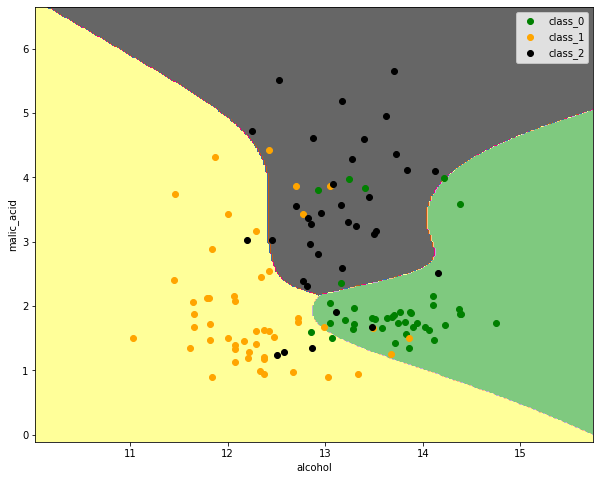

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (10, 8)

n_classes = 3
plot_colors = ['g', 'orange', 'black']
plot_step = 0.02

x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1

xx, yy =  torch.meshgrid(torch.arange(x_min, x_max, plot_step),
                         torch.arange(y_min, y_max, plot_step))

preds = wine_net.inference(
    torch.cat([xx.reshape(-1, 1), yy.reshape(-1, 1)], dim=1))

preds_class = preds.data.numpy().argmax(axis=1)
preds_class = preds_class.reshape(xx.shape)
plt.contourf(xx, yy, preds_class, cmap='Accent')

for i, color in zip(range(n_classes), plot_colors):
    indexes = np.where(y_train == i)
    plt.scatter(X_train[indexes, 0], 
                X_train[indexes, 1], 
                c=color, 
                label=data.target_names[i],
                cmap='Accent')
    plt.xlabel(data.feature_names[0])
    plt.ylabel(data.feature_names[1])
    plt.legend()